# Libraries

In [1]:
import random
import torch
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification
from datasets import load_from_disk

from config import DEVICE
from generate_results import generate_answers, generate_SE
from my_utils.data import load_ds, sample_ds, load_results
from my_utils.semantic_entropy import is_entailment_embeddings, is_entailment_transformer, is_entailment_llm
from my_utils.metrics import auroc_entail_models, visualise_results


print(DEVICE)
seed = 42
random.seed(seed)

cuda


# Load datasets

In [2]:
n_samples = 400
_, triviaqa_val = load_ds("trivia_qa", seed)
_, squad_val = load_ds("squad", seed)
_, svamp_val = load_ds("svamp", seed)
_, nq_val = load_ds("nq", seed)


triviaqa_sample = sample_ds(triviaqa_val, n_samples, seed, "trivia_qa")
squad_sample = sample_ds(squad_val, n_samples, seed, "squad")
svamp_sample = sample_ds(svamp_val, n_samples, seed, "svamp")
nq_sample = sample_ds(nq_val, n_samples, seed, "nq")
del triviaqa_val, squad_val, svamp_val, nq_val

datasets = [triviaqa_sample, squad_sample, svamp_sample, nq_sample]

Dataset:  trivia_qa
Dataset({
    features: ['id', 'question', 'context', 'answers'],
    num_rows: 400
}) 

Dataset:  squad
Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 400
}) 

Dataset:  svamp
Dataset({
    features: ['ID', 'Body', 'Question', 'Equation', 'Answer', 'Type', 'question_concat', 'question', 'context', 'type', 'equation', 'id', 'answers'],
    num_rows: 400
}) 

Dataset:  nq
Dataset({
    features: ['question', 'answer', 'answers', 'context', 'id'],
    num_rows: 400
}) 



# Generate answers

In [3]:
# LLM
Gemma_model = AutoModelForCausalLM.from_pretrained("google/gemma-2-2b-it", device_map="auto", torch_dtype=torch.bfloat16)
Gemma_tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b-it")

data_answer_path = "data/answers/"
generate_answers(datasets, data_answer_path, Gemma_model, Gemma_tokenizer)

del Gemma_model, Gemma_tokenizer
torch.cuda.empty_cache()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


Generating responses for trivia_qa dataset...


100%|██████████| 400/400 [25:19<00:00,  3.80s/it]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating responses for squad dataset...


100%|██████████| 400/400 [31:12<00:00,  4.68s/it]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating responses for svamp dataset...


100%|██████████| 400/400 [36:14<00:00,  5.44s/it] 


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating responses for nq dataset...


100%|██████████| 400/400 [27:18<00:00,  4.10s/it]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]

# Load Answers

In [2]:
triviaqa_sample = load_from_disk("data/answers/trivia_qa")
squad_sample = load_from_disk("data/answers/squad")
svamp_sample = load_from_disk("data/answers/svamp")
nq_sample = load_from_disk("data/answers/nq")
Gemma_tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b-it")

datasets = [triviaqa_sample, squad_sample, svamp_sample, nq_sample]

# Calculate Semantic Entropy for different entailment models

In [4]:
# Sentence Embeddings
All_mpnet_model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2').to(DEVICE)
All_mpnet_tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
data_entail_path = "data/transformers/all_mpnet_base_v2/109M/"
print("\nAll-mpnet-base-v2")
generate_SE(datasets, data_entail_path, Gemma_tokenizer, All_mpnet_model, All_mpnet_tokenizer, is_entailment_embeddings)
del All_mpnet_model, All_mpnet_tokenizer
torch.cuda.empty_cache()


All-mpnet-base-v2

Generating Semantic Entropies for trivia_qa dataset...


100%|██████████| 400/400 [00:32<00:00, 12.29it/s]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for squad dataset...


100%|██████████| 400/400 [00:33<00:00, 11.96it/s]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for svamp dataset...


100%|██████████| 400/400 [00:35<00:00, 11.37it/s]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for nq dataset...


100%|██████████| 400/400 [00:33<00:00, 12.09it/s]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]

In [ ]:
# Entailment Transformer
Roberta_model = AutoModelForSequenceClassification.from_pretrained("roberta-large-mnli").to(DEVICE)
Roberta_tokenizer = AutoTokenizer.from_pretrained("roberta-large-mnli")
data_entail_path = "data/transformers/roberta/356M/"
print("\nRoberta")
generate_SE(datasets, data_entail_path, Gemma_tokenizer, Roberta_model, Roberta_tokenizer, is_entailment_transformer)
del Roberta_model, Roberta_tokenizer
torch.cuda.empty_cache()


# Entailment LLMs
Qwen_model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct", torch_dtype="auto", device_map="auto").to(DEVICE)
Qwen_tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct")
data_entail_path = "data/llms/qwen/0.5B/"
print("\nQwen 0.5B")
generate_SE(datasets, data_entail_path, Gemma_tokenizer, Qwen_model, Qwen_tokenizer, is_entailment_llm)
del Qwen_model, Qwen_tokenizer
torch.cuda.empty_cache()

Qwen_model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-1.5B-Instruct", torch_dtype="auto", device_map="auto").to(DEVICE)
Qwen_tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-1.5B-Instruct")
data_entail_path = "data/llms/qwen/1.5B/"
print("\nQwen 1.5B")
generate_SE(datasets, data_entail_path, Gemma_tokenizer, Qwen_model, Qwen_tokenizer, is_entailment_llm)
del Qwen_model, Qwen_tokenizer
torch.cuda.empty_cache()

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Roberta

Generating Semantic Entropies for trivia_qa dataset...


  0%|          | 0/400 [00:00<?, ?it/s]c:\Users\tasso\anaconda3\envs\mscs\Lib\site-packages\transformers\models\roberta\modeling_roberta.py:370: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
100%|██████████| 400/400 [01:45<00:00,  3.80it/s]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for squad dataset...


100%|██████████| 400/400 [01:46<00:00,  3.75it/s]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for svamp dataset...


100%|██████████| 400/400 [01:49<00:00,  3.66it/s]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for nq dataset...


100%|██████████| 400/400 [01:47<00:00,  3.73it/s]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Qwen 0.5B

Generating Semantic Entropies for trivia_qa dataset...


100%|██████████| 400/400 [41:08<00:00,  6.17s/it] 


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for squad dataset...


100%|██████████| 400/400 [41:26<00:00,  6.22s/it]  


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for svamp dataset...


100%|██████████| 400/400 [1:56:04<00:00, 17.41s/it]  


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for nq dataset...


100%|██████████| 400/400 [27:07<00:00,  4.07s/it] 


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Qwen 1.5B

Generating Semantic Entropies for trivia_qa dataset...


100%|██████████| 400/400 [15:02<00:00,  2.26s/it]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for squad dataset...


100%|██████████| 400/400 [14:36<00:00,  2.19s/it]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for svamp dataset...


100%|██████████| 400/400 [10:04<00:00,  1.51s/it]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for nq dataset...


100%|██████████| 400/400 [15:24<00:00,  2.31s/it]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]

In [ ]:
Qwen_model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-3B-Instruct", torch_dtype="auto", device_map="auto").to(DEVICE)
Qwen_tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-3B-Instruct")
data_entail_path = "data/llms/qwen/3.0B/"
print("\nQwen 3B")
generate_SE(datasets, data_entail_path, Gemma_tokenizer, Qwen_model, Qwen_tokenizer, is_entailment_llm)
del Qwen_model, Qwen_tokenizer
torch.cuda.empty_cache()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


Qwen 3B

Generating Semantic Entropies for trivia_qa dataset...


  0%|          | 0/400 [00:00<?, ?it/s]c:\Users\tasso\anaconda3\envs\mscs\Lib\site-packages\transformers\models\qwen2\modeling_qwen2.py:544: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
100%|██████████| 400/400 [57:06<00:00,  8.57s/it]  


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for squad dataset...


100%|██████████| 400/400 [1:49:38<00:00, 16.45s/it]  


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for svamp dataset...


100%|██████████| 400/400 [2:25:00<00:00, 21.75s/it]  


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]


Generating Semantic Entropies for nq dataset...


100%|██████████| 400/400 [1:05:43<00:00,  9.86s/it]


Saving the dataset (0/1 shards):   0%|          | 0/400 [00:00<?, ? examples/s]

# Load Results

In [2]:
transformers_results = load_results("data/transformers")
llm_results = load_results("data/llms")

Loaded nq from all_mpnet_base_v2/109M
Loaded squad from all_mpnet_base_v2/109M
Loaded svamp from all_mpnet_base_v2/109M
Loaded trivia_qa from all_mpnet_base_v2/109M

Loaded nq from roberta/356M
Loaded squad from roberta/356M
Loaded svamp from roberta/356M
Loaded trivia_qa from roberta/356M

Loaded nq from qwen/0.5B
Loaded squad from qwen/0.5B
Loaded svamp from qwen/0.5B
Loaded trivia_qa from qwen/0.5B

Loaded nq from qwen/1.5B
Loaded squad from qwen/1.5B
Loaded svamp from qwen/1.5B
Loaded trivia_qa from qwen/1.5B

Loaded nq from qwen/3.0B
Loaded squad from qwen/3.0B
Loaded svamp from qwen/3.0B
Loaded trivia_qa from qwen/3.0B



# Calculate Metrics


AUROC scores for Transformer All_mpnet_base_v2 109M
nq                   dataset:   0.4761
squad                dataset:   0.4856
svamp                dataset:   0.5708
trivia_qa            dataset:   0.5706

AUROC scores for Transformer Roberta 356M
nq                   dataset:   0.6535
squad                dataset:   0.5342
svamp                dataset:   0.5722
trivia_qa            dataset:   0.6088

AUROC scores for LLM Qwen 0.5B
nq                   dataset:   0.5678
squad                dataset:   0.5033
svamp                dataset:   0.4001
trivia_qa            dataset:   0.5779

AUROC scores for LLM Qwen 1.5B
nq                   dataset:   0.5916
squad                dataset:   0.4805
svamp                dataset:   0.5702
trivia_qa            dataset:   0.5577

AUROC scores for LLM Qwen 3.0B
nq                   dataset:   0.5200
squad                dataset:   0.4646
svamp                dataset:   0.5027
trivia_qa            dataset:   0.5717


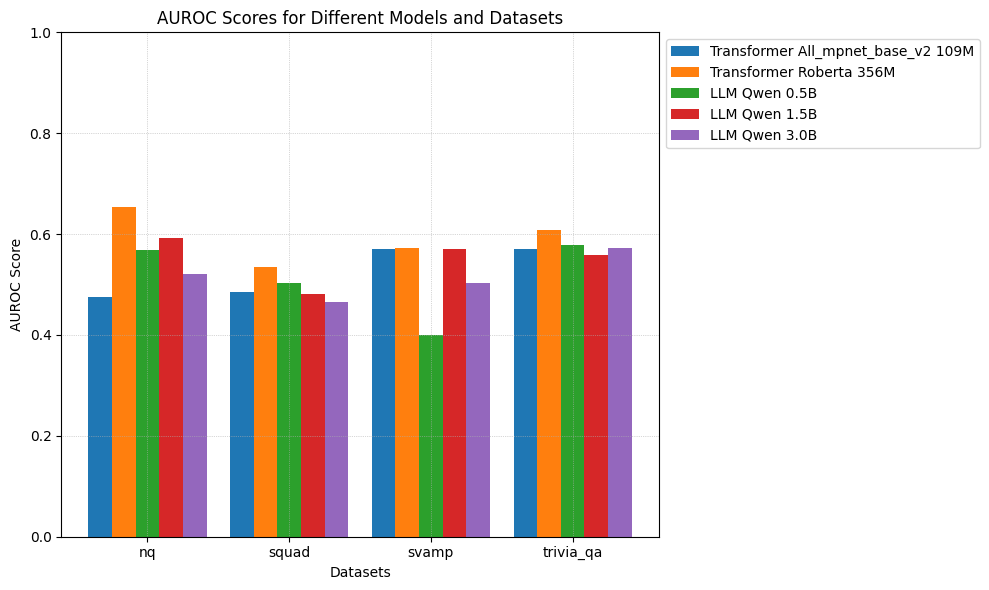

In [3]:
tr = auroc_entail_models(transformers_results, "Transformer")
lr = auroc_entail_models(llm_results, "LLM")

models_names = tr[0]+lr[0]
results = tr[1]+lr[1]

datasets_names = ["nq", "squad", "svamp", "trivia_qa"]
visualise_results(models_names, datasets_names, results)